In [81]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import copy
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [82]:
"""
Encode categorical variables
"""
def encode(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)

    ordinal_encoder = OrdinalEncoder()
    label_df = df.copy()
    label_df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

    return label_df

"""
Fill missing values
"""
def fill(df):
    label_df = copy.deepcopy(df)

    # Fill missing values
    label_df['energy_star_rating'] = label_df['energy_star_rating'].fillna(label_df['energy_star_rating'].mean())
    label_df['direction_max_wind_speed'] = label_df['direction_max_wind_speed'].fillna(1.0)
    label_df['direction_peak_wind_speed'] = label_df['direction_peak_wind_speed'].fillna(1.0)
    label_df['max_wind_speed'] = label_df['max_wind_speed'].fillna(1.0)
    label_df['days_with_fog'] = label_df['days_with_fog'].fillna(label_df['days_with_fog'].mean())
    label_df = label_df.fillna(0)
    
    return label_df

"""
Encode categorical variables and fill missing values with 0
"""
def encode_and_fill(df):
    label_df = encode(df)
    label_df = fill(label_df)
    return label_df

"""
Replace groups of highly correlated features with their average values
"""
def avg_features(df):
    Xtraindf = copy.deepcopy(df)
    Xtraindf['Avg_min_temp_winter'] = (Xtraindf['january_min_temp'] + Xtraindf['february_min_temp'] + Xtraindf['march_min_temp'] + Xtraindf['april_min_temp'] + Xtraindf['october_min_temp'] + Xtraindf['november_min_temp'] + Xtraindf['december_min_temp'])/7
    Xtraindf['Avg_max_temp_winter'] = (Xtraindf['january_max_temp'] + Xtraindf['february_max_temp'] + Xtraindf['march_max_temp'] + Xtraindf['april_max_temp'] + Xtraindf['october_max_temp'] + Xtraindf['november_max_temp'] + Xtraindf['december_max_temp'])/7
    Xtraindf['Avg_temp_winter'] = (Xtraindf['january_avg_temp'] + Xtraindf['february_avg_temp'] + Xtraindf['march_avg_temp'] + Xtraindf['april_avg_temp'] + Xtraindf['october_avg_temp'] + Xtraindf['november_avg_temp'] + Xtraindf['december_avg_temp'])/7
    Xtraindf['Avg_min_temp_summer'] = (Xtraindf['may_min_temp'] + Xtraindf['june_min_temp'] + Xtraindf['july_min_temp'] + Xtraindf['august_min_temp'] + Xtraindf['september_min_temp'])/5 
    Xtraindf['Avg_max_temp_summer'] = (Xtraindf['may_max_temp'] + Xtraindf['june_max_temp'] + Xtraindf['july_max_temp'] + Xtraindf['august_max_temp'] + Xtraindf['september_max_temp'])/5
    Xtraindf['Avg_temp_summer'] = (Xtraindf['may_avg_temp'] + Xtraindf['june_avg_temp'] + Xtraindf['july_avg_temp'] + Xtraindf['august_avg_temp'] + Xtraindf['september_avg_temp'])/5 
    Xtraindf['Avg_days_below30F'] = (Xtraindf['days_below_30F'] + Xtraindf['days_below_20F'] + Xtraindf['days_below_10F'] + Xtraindf['days_below_0F'])/4

    # Drop features
    rmv_features = ['january_min_temp','february_min_temp','march_min_temp','april_min_temp','october_min_temp','november_min_temp','december_min_temp']
    rmv_features += ['january_max_temp','february_max_temp','march_max_temp','april_max_temp','october_max_temp','november_max_temp','december_max_temp']
    rmv_features += ['january_avg_temp','february_avg_temp','march_avg_temp','april_avg_temp','october_avg_temp','november_avg_temp','december_avg_temp']
    rmv_features += ['may_min_temp','june_min_temp','july_min_temp','august_min_temp','september_min_temp']
    rmv_features += ['may_max_temp','june_max_temp','july_max_temp','august_max_temp','september_max_temp']
    rmv_features += ['may_avg_temp','june_avg_temp','july_avg_temp','august_avg_temp','september_avg_temp']
    rmv_features += ['days_below_30F','days_below_20F','days_below_10F','days_below_0F']
    Xtraindf = Xtraindf.drop(columns=rmv_features)

    return Xtraindf

"""
Normalize all the columns of a DataFrame
"""
def normalize_data(df):
    data_norm = normalize(df, axis=0)
    df_norm = pd.DataFrame(data_norm, columns=df.columns)
    return df_norm

"""
Run random forest on DataFrame, return RF model
"""
def random_forest(df, max_depth=8):
    # Get X and y vectors
    df_copy = copy.deepcopy(df)
    y = np.array(df_copy['site_eui']).reshape(-1,1)
    X = df_copy.drop(columns=['site_eui', 'id'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Run random forest
    rf = RandomForestRegressor(n_estimators=40, max_depth=max_depth)
    rf.fit(X_train, y_train)

    return rf


/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.3953574473264283


Text(0, 0.5, 'Predicted site_eui Values')

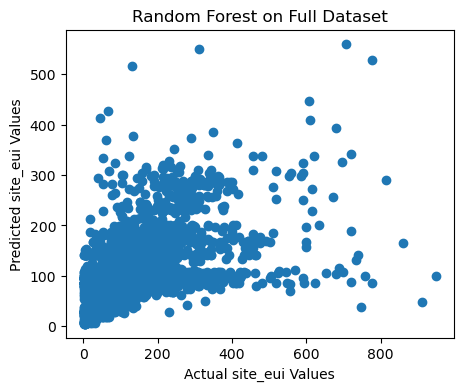

In [83]:
### RANDOM FOREST ON FULL DATA ###

# Get data
train_df = pd.read_csv('train.csv')
train_df = encode_and_fill(train_df)
y = np.array(train_df['site_eui']).reshape(-1,1)
X = train_df.drop(columns=['site_eui', 'id'])
X = avg_features(X)
X = normalize_data(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Run random forest
rf = RandomForestRegressor(n_estimators=100, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Full Dataset")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")

In [84]:
### SPLIT DATA BASED ON BUILDING TYPE ###

train_df = pd.read_csv('train.csv')

# Separate data for commercial and residential buildings
com_train_df = train_df.loc[train_df['building_class'] == 'Commercial']
res_train_df = train_df.loc[train_df['building_class'] == 'Residential']
com_train_df = com_train_df.drop(columns=['building_class'])
res_train_df = res_train_df.drop(columns=['building_class'])

# Original DataFrames before encoding, filling, averaging, and normalizing
orig_com_df = copy.deepcopy(com_train_df)
orig_res_df = copy.deepcopy(res_train_df)

# Encode and fill, average
com_train_df = encode_and_fill(com_train_df)
com_train_df = avg_features(com_train_df)
res_train_df = encode_and_fill(res_train_df)
res_train_df = avg_features(res_train_df)

# Normalize
com_train_df = normalize_data(com_train_df)
res_train_df = normalize_data(res_train_df)

y_com_train = np.array(com_train_df['site_eui']).reshape(-1,1)
X_com_train = com_train_df.drop(columns=['site_eui', 'id'])
y_res_train = np.array(res_train_df['site_eui']).reshape(-1,1)
X_res_train = res_train_df.drop(columns=['site_eui', 'id'])

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.4274023042756878


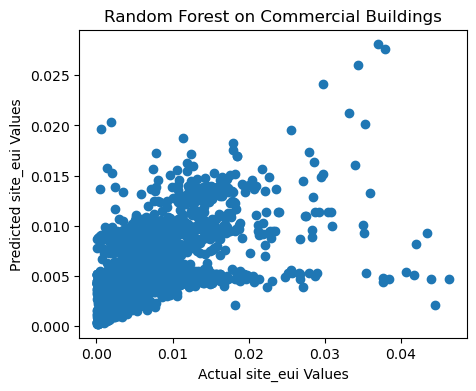

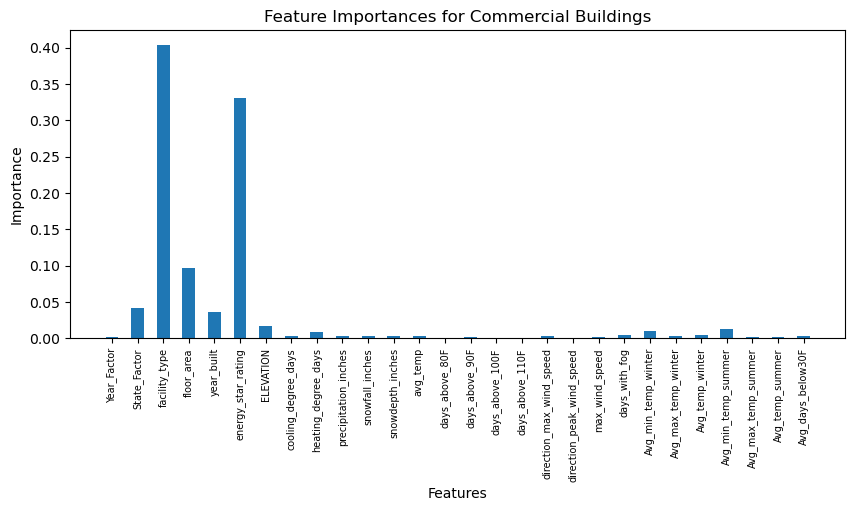

In [85]:
### RANDOM FOREST ON COMMERCIAL BUILDINGS ###
X_train, X_test, y_train, y_test = train_test_split(X_com_train, y_com_train, test_size=0.3)
print(type(X_train))
print(type(y_train))

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Commercial Buildings")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")
plt.show()

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_com_train.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Commercial Buildings")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.3259141416804572


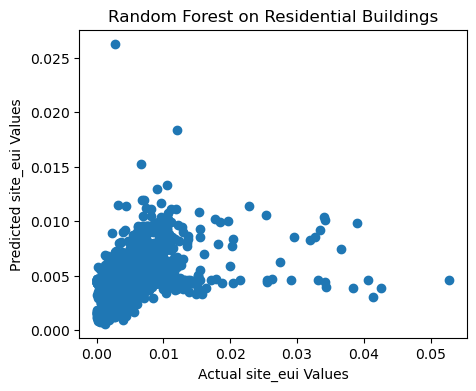

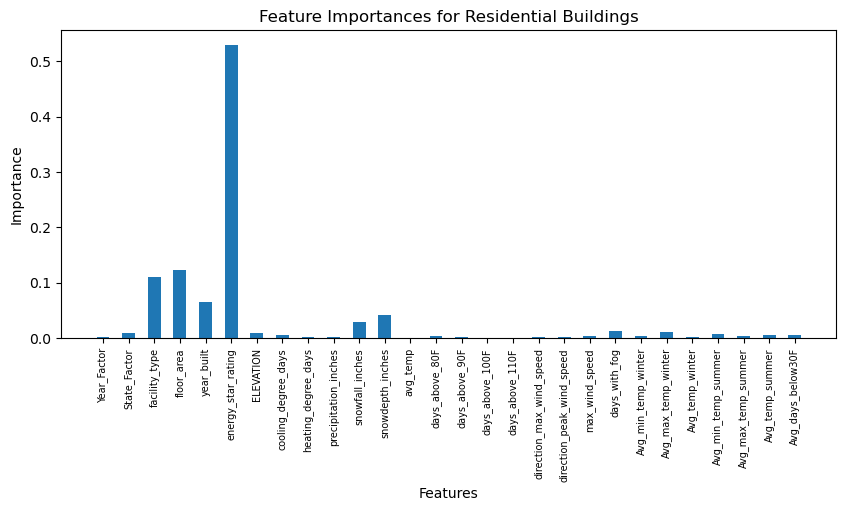

In [86]:
### RANDOM FOREST ON RESIDENTIAL BUILDINGS ###
X_train, X_test, y_train, y_test = train_test_split(X_res_train, y_res_train, test_size=0.3)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Residential Buildings")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_com_train.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Residential Buildings")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

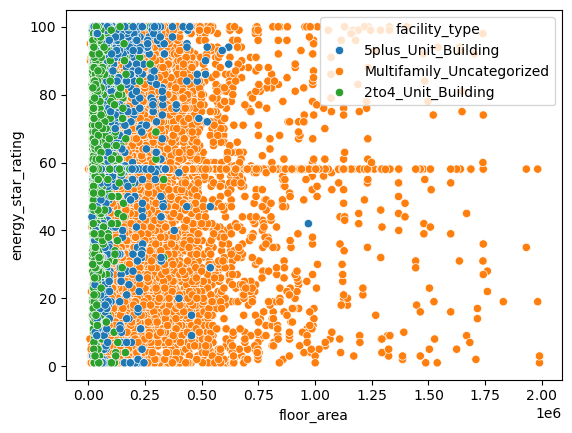

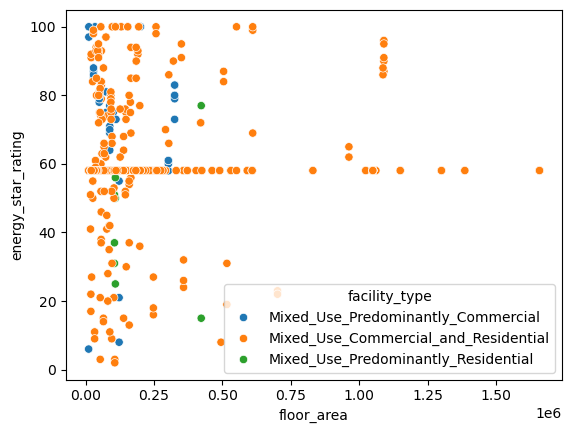

In [87]:
### PLOT FLOOR AREA AND ENERGY STAR RATING FOR RESIDENTIAL ###

# Plot floor area and energy star rating with hue = facility type
plot_res_df = fill(orig_res_df)

# Plot unit and multifamily buildings
unit_res_facilities = ['5plus_Unit_Building','Multifamily_Uncategorized','2to4_Unit_Building']
unit_res_df = plot_res_df.loc[plot_res_df['facility_type'].isin(unit_res_facilities)]
sns.scatterplot(unit_res_df,x='floor_area',y='energy_star_rating',hue='facility_type')
plt.show()

# Plot mixed use facilities
mixed_res_facilities = ['Mixed_Use_Predominantly_Commercial','Mixed_Use_Commercial_and_Residential','Mixed_Use_Predominantly_Residential']
mixed_res_df = plot_res_df.loc[plot_res_df['facility_type'].isin(mixed_res_facilities)]
sns.scatterplot(mixed_res_df,x='floor_area',y='energy_star_rating',hue='facility_type')
plt.show()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.5080098147368179


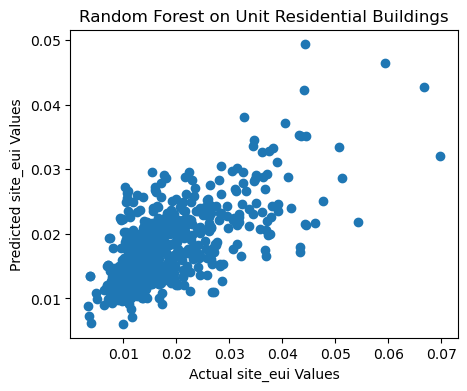

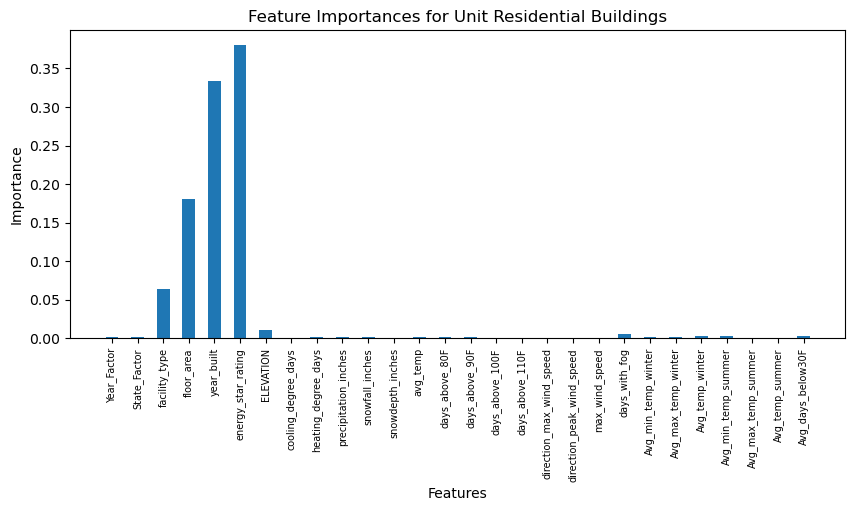

In [88]:
### RANDOM FOREST ON UNIT BUILDINGS ###
unit_res_df = plot_res_df.loc[plot_res_df['facility_type'].isin(['5plus_Unit_Building','2to4_Unit_Building'])]
unit_res_df = encode_and_fill(unit_res_df)
unit_res_df = avg_features(unit_res_df)
unit_res_df = normalize_data(unit_res_df)

y_unit = np.array(unit_res_df['site_eui']).reshape(-1,1)
X_unit = unit_res_df.drop(columns=['site_eui', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X_unit, y_unit, test_size=0.3)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Unit Residential Buildings")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_unit.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Unit Residential Buildings")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.2737725438293339


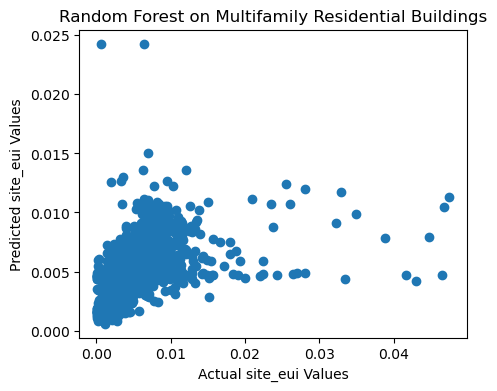

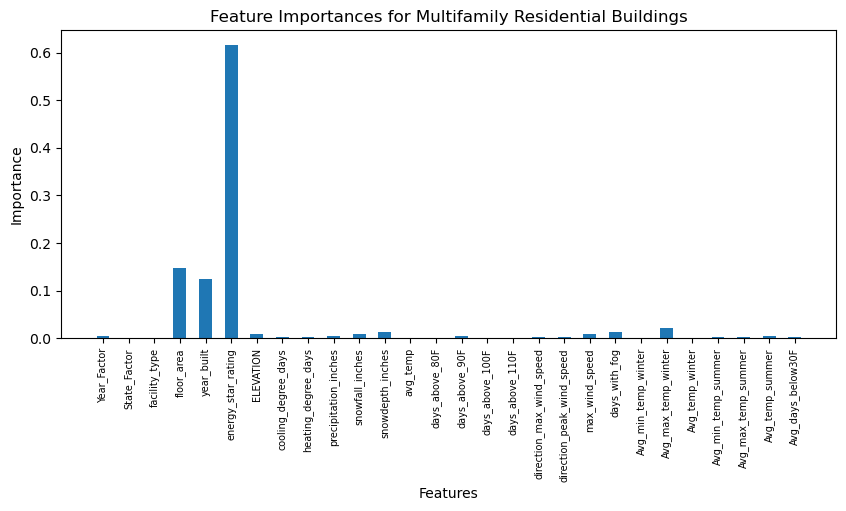

In [89]:
### RANDOM FOREST ON MULTIFAMILY RESIDENTIAL BUILDINGS ###
res_df = plot_res_df.loc[plot_res_df['facility_type'].isin(['Multifamily_Uncategorized'])]
res_df = encode_and_fill(res_df)
res_df = avg_features(res_df)
res_df = normalize_data(res_df)

y = np.array(res_df['site_eui']).reshape(-1,1)
X = res_df.drop(columns=['site_eui', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Multifamily Residential Buildings")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_unit.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Multifamily Residential Buildings")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Score: 0.32013884345802857


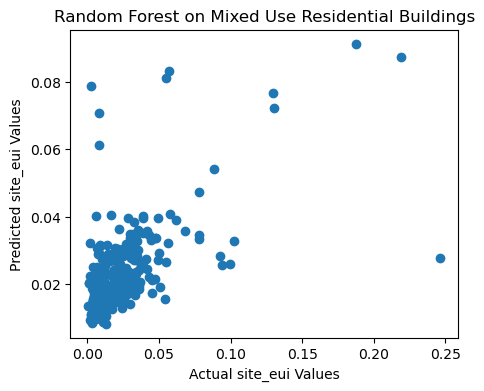

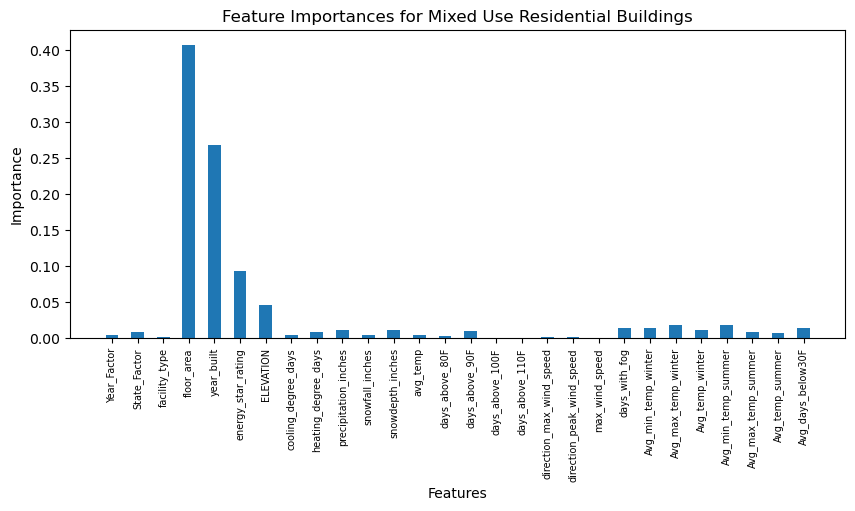

In [94]:
### RANDOM FOREST ON MIXED USE RESIDENTIAL BUILDINGS ###
res_df = mixed_res_df
res_df = encode_and_fill(res_df)
res_df = avg_features(res_df)
res_df = normalize_data(res_df)

y = np.array(res_df['site_eui']).reshape(-1,1)
X = res_df.drop(columns=['site_eui', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Mixed Use Residential Buildings")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_unit.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Mixed Use Residential Buildings")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [91]:
### RANDOM FOREST ON GROCERY STORES (COMMERCIAL) ###

# Separate data for grocery facility type
commercial_df = train_df.loc[train_df['building_class'] == 'Commercial']
commercial_df = commercial_df.drop(columns=['building_class'])
grocery_df = com_train_df.loc[commercial_df['facility_type'] == 'Grocery_store_or_food_market']
grocery_df = grocery_df.drop(columns=['facility_type'])

# Encode and fill
grocery_df = encode_and_fill(grocery_df)

y_grocery = np.array(grocery_df['site_eui']).reshape(-1,1)
X_grocery = grocery_df.drop(columns=['site_eui', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X_grocery, y_grocery, test_size=0.2)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Grocery Stores")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")
plt.show()

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_grocery.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Grocery Stores")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
### RANDOM FOREST ON FOOD FACILITIES (COMMERCIAL) ###

# Separate data for grocery facility type
food_facilities = ['Grocery_store_or_food_market','Food_Service_Uncategorized','Food_Service_Other','Food_Service_Restaurant_or_cafeteria', 'Food_Sales']
commercial_df = train_df.loc[train_df['building_class'] == 'Commercial']
commercial_df = commercial_df.drop(columns=['building_class'])
food_df = com_train_df.loc[commercial_df['facility_type'].isin(food_facilities)]
food_df = food_df.drop(columns=['facility_type'])

# Encode and fill
food_df = encode_and_fill(food_df)

y_food = np.array(food_df['site_eui']).reshape(-1,1)
X_food = food_df.drop(columns=['site_eui', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X_food, y_food, test_size=0.24)

# Run random forest
rf = RandomForestRegressor(n_estimators=40, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score:", score)

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test,y_pred)
plt.title("Random Forest on Food Facilities")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")
plt.show()

# Plot Feature Importances
plt.figure(figsize=(10,4))
features = np.array(X_food.columns)
plt.bar(features, rf.feature_importances_, width=0.5)
plt.xticks(fontsize=7, rotation=90)
plt.title("Feature Importances for Food Facilities")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).